In [1]:
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.spatial import distance_matrix
import numpy as np
import time

In [2]:
tp_url = "https://en.wikipedia.org/wiki/List_of_districts_of_Madhya_Pradesh"
tables = pd.read_html(tp_url)
dist_table = tables[0]

In [3]:
# read data
with open("data/boundary.pkl", "rb") as file:
    dis_bd = pkl.load(file)

In [8]:
# get the centroid of each area
locs = []
centers = []
for tp_dis in dis_bd:
    locs.append(tp_dis)
    tp_ct = dis_bd[tp_dis].to_crs(epsg=32618).centroid[0]
    centers.append((tp_ct.x, tp_ct.y))
# calculate the distance matrix
distance_m = distance_matrix(centers, centers)

In [9]:
# WARNING!!!: the 2011 data was used. It should be the 2021 data
pops = np.array(list(dist_table["Population (2011)[5]"]))
pops[38] = 40192
pops = pops*(84860000/pops.sum())

In [10]:
# calculate transition matrix
tran_Mo = pops.reshape(-1,1).dot(pops.reshape(1,-1))/distance_m**2
np.fill_diagonal(tran_Mo, 0)
tran_M = (tran_Mo.T / tran_Mo.sum(axis=1)).T
rele = pops/pops.sum()

C:\Users\wwy10\AppData\Local\Temp\ipykernel_30288\3356370743.py:2: RuntimeWarning: divide by zero encountered in divide
  tran_Mo = pops.reshape(-1,1).dot(pops.reshape(1,-1))/distance_m**2


In [11]:
def fast_choose_from_2D(probs, n):
    cumulative_prob_array = np.cumsum(probs, axis=1) # create a cumulative sum array for the probabilities
    random_values = np.random.rand(n, 1) # Generate random values for sampling
    # Find where the random values fall within the cumulative probability ranges
    next_loc = (random_values < cumulative_prob_array).argmax(axis=1)
    return next_loc

In [61]:
# setting of parameters
a = 14
b = 1
p = 0.6
gam = 0.21

size =5000000 # number of people to generate
# initlaization
MaxT = 385 # number of days
start_time = time.time()
time_G = np.array([1 for i in range(size)], dtype="int") # time that has passed
current_locs = np.random.choice(len(locs), size=size, replace=True, p=rele) # initial locations
movements = np.full((size, MaxT), -1, dtype="int") # movement list
movements[:,0]=current_locs
num_visited = np.ones(size, dtype="int")
locs_visited = np.zeros((size, len(locs))) # time of locations visited
locs_visited[np.array([i for i in range(size)], dtype="int"), current_locs] = 1
while (movements[:, -1]==-1).sum() != 0: # if there are persons whose last locations are unknown
    tp_ids = np.where(movements[:, -1]==-1)[0] # select people whose last locations are unknown
    tp_size = len(tp_ids)
    # calculate the wait time
    tp_wait_time = np.random.gamma(a,1/b,size=tp_size) # sample from gamma distribution
    tp_wait_time = np.rint(tp_wait_time).astype("int") # round to the nearest integer
    tp_wait_time[tp_wait_time==0] = 1 # if there is zero, make it one
    # add the number of current locations to the existing locations
    tp_end_time = time_G[tp_ids]+tp_wait_time
    for i in range(len(tp_ids)):
        if tp_end_time[i] <= MaxT:
            movements[tp_ids[i], time_G[tp_ids[i]]:tp_end_time[i]-1] = movements[tp_ids[i], time_G[tp_ids[i]]-1]
        else:
            movements[tp_ids[i], time_G[tp_ids[i]]:] = movements[tp_ids[i], time_G[tp_ids[i]]-1]

    time_G[tp_ids] += tp_wait_time
    
    # used for debug
#     if ((time_G[tp_ids]>MaxT)*((movements[tp_ids][:, -1])==-1)).sum()>0:
#         print(np.where((time_G[tp_ids]>MaxT)*((movements[tp_ids][:, -1])==-1)))
#         break
    
    if (movements[:, -1]==-1).sum() != 0: # if there are persons whose last locations are unknown
        tp_ids = np.where(movements[:, -1]==-1)[0] # select people whose last location is unknown        
        tp_size = len(tp_ids)
        # calculate if explore
        tp_p_explore = p*num_visited[tp_ids]**(-gam)
        if_explore = np.random.uniform(size=tp_size)<tp_p_explore # if the person explore
        n_explore = if_explore.sum()

        # for explorers, calculate the probabilities for new locations
        tp_probs_masked = tran_M[current_locs[tp_ids[if_explore]]]*(locs_visited[tp_ids[if_explore]]==0)
        tp_probs = (tp_probs_masked.T / tp_probs_masked.sum(axis=1)).T
        # choose the new location
        next_loc = fast_choose_from_2D(tp_probs, n_explore)
        # update variables for explorers
        current_locs[tp_ids[if_explore]] = next_loc
        movements[tp_ids[if_explore], time_G[tp_ids[if_explore]]-1] = next_loc
        num_visited[tp_ids[if_explore]] += 1
        locs_visited[tp_ids[if_explore], next_loc] += 1

        # for returners, visit one of the previously visited locations
        # note that people may return to the same location
        n_return = tp_size-n_explore
        if_return = (if_explore==False)
        tp_times = locs_visited[tp_ids[if_return]]
        tp_probs = (tp_times.T / tp_times.sum(axis=1)).T
        next_loc = fast_choose_from_2D(tp_probs, n_return)
        # update variables for returners
        current_locs[tp_ids[if_return]] = next_loc
        movements[tp_ids[if_return], time_G[tp_ids[if_return]]-1] = next_loc
        locs_visited[tp_ids[if_return], next_loc] += 1
        
    print((movements[:, -1]!=-1).sum())
print(time.time()-start_time)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
148
2940
31849
200965
771407
1915193
3303756
4340525
4824681
4968710
4996279
4999707
4999984
4999999
5000000
411.69723200798035


In [62]:
# examination of movements
for i in range(MaxT):
    if (movements[:,i]==-1).sum() != 0:
        print(i)

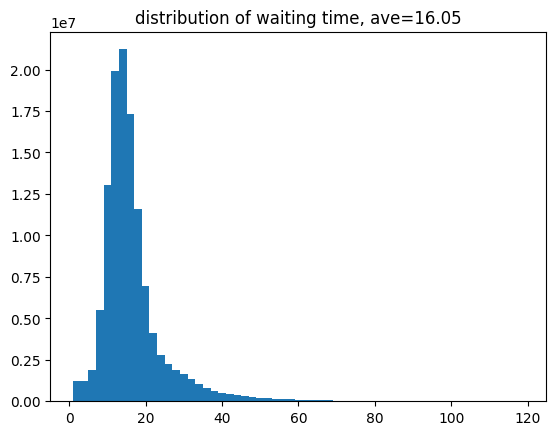

In [63]:
# estimate the distribution of the number of visits and the time of stays (waiting time)
stays_diff = movements[:, 1:] - movements[:, :-1]
day_inds = np.where(stays_diff.reshape(-1)!=0)[0]
start_days = np.array([i*MaxT for i in range(size)], dtype="int")
days = np.concatenate([day_inds, start_days])
days.sort()
days = days[1:] - days[:-1]
_ = plt.hist(days, bins=list(range(1,120,2)))
plt.title("distribution of waiting time, ave={:.2f}".format(days.mean()))
plt.show()

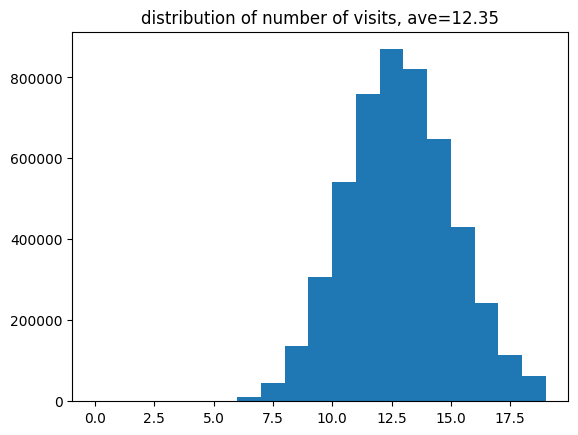

In [64]:
visits = np.zeros(size, dtype="int")
uni_locs = np.sort(movements, axis=1)
visits = (uni_locs[:,1:] != uni_locs[:,:-1]).sum(axis=1)+1
_ = plt.hist(visits, bins=list(range(20)))
plt.title("distribution of number of visits, ave={:.2f}".format(visits.mean()))
plt.show()